# Data Preparation and Quality
Lecture Data Engineering and Analytics<br>
Eva Zangerle

In [1]:
# import required packages
import glob
import json
import math
import os
import re
import io
import traceback
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, median_abs_deviation, norm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
# set seaborn style
sns.set_style("darkgrid")

In [3]:
# specify data directory
data_dir = "../data"

In [4]:
# show all outputs
InteractiveShell.ast_node_interactivity = "all"

In [5]:
%load_ext watermark
%watermark -a "Eva Zangerle" --updated --date --time --iversions --githash

Author: Eva Zangerle

Last updated: 2024-10-23 08:31:28

Git hash: c43ff54ee3a3cf09e642725e178b0b4377201e47

sklearn    : 1.5.2
pandas     : 2.2.3
statsmodels: 0.14.3
IPython    : 8.27.0
numpy      : 2.1.1
seaborn    : 0.13.2
json       : 2.0.9
matplotlib : 3.9.2
re         : 2.2.1
scipy      : 1.14.1



## CSV

### Initial CSV Wrangling (and some quick showcasing of pandas)
Example adapted from CleanData.

In [6]:
students = pd.read_csv(os.path.join(data_dir, "student-scores.csv"))

In [7]:
# inspect resulting dataframe
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          6 non-null      int64 
 1   Last Name   6 non-null      object
 2   First Name  6 non-null      object
 3   4th Grade   6 non-null      object
 4   5th Grade   6 non-null      object
 5   6th Grade   6 non-null      object
dtypes: int64(1), object(5)
memory usage: 420.0+ bytes


In [8]:
students.shape

(6, 6)

In [9]:
students.columns

Index(['ID', 'Last Name', 'First Name', '4th Grade', '5th Grade', '6th Grade'], dtype='object')

In [10]:
students

,ID,Last Name,First Name,4th Grade,5th Grade,6th Grade
0,1,Johnson,Mia,A,B+,A-
1,2,Lopez,Liam,B,B,A+
2,3,Lee,Isabella,C,C-,B-
3,4,Fisher,Mason,B,B-,C+
4,5,Gupta,Olivia,B,A+,A
5,6,Robinson,Sophia,A+,B-,A


In [11]:
# select single column, returns Series (numpy ndarray)
students["Last Name"]

0     Johnson
1       Lopez
2         Lee
3      Fisher
4       Gupta
5    Robinson
Name: Last Name, dtype: object

In [12]:
# select multiple columns, returns dataframe (requires param to be a list)
grades = students[["4th Grade", "5th Grade", "6th Grade"]]

In [13]:
grades.drop(columns=["4th Grade"])

,5th Grade,6th Grade
0,B+,A-
1,B,A+
2,C-,B-
3,B-,C+
4,A+,A
5,B-,A


In [14]:
# select via row position
students.iloc[1]
students.iloc[[3, 5]]
students.iloc[2:5]

ID                2
Last Name     Lopez
First Name     Liam
4th Grade         B
5th Grade         B
6th Grade        A+
Name: 1, dtype: object

,ID,Last Name,First Name,4th Grade,5th Grade,6th Grade
3,4,Fisher,Mason,B,B-,C+
5,6,Robinson,Sophia,A+,B-,A


,ID,Last Name,First Name,4th Grade,5th Grade,6th Grade
2,3,Lee,Isabella,C,C-,B-
3,4,Fisher,Mason,B,B-,C+
4,5,Gupta,Olivia,B,A+,A


In [15]:
# set index on row identifier
students = students.set_index("ID")
students

,Last Name,First Name,4th Grade,5th Grade,6th Grade
ID,,,,,
1,Johnson,Mia,A,B+,A-
2,Lopez,Liam,B,B,A+
3,Lee,Isabella,C,C-,B-
4,Fisher,Mason,B,B-,C+
5,Gupta,Olivia,B,A+,A
6,Robinson,Sophia,A+,B-,A


In [16]:
# use index to access rows
students.loc[1]

Last Name     Johnson
First Name        Mia
4th Grade           A
5th Grade          B+
6th Grade          A-
Name: 1, dtype: object

In [17]:
# Generic conversion of letter grades to numbers
def num_score(x):
    to_num = {
        "A+": 4.3,
        "A": 4,
        "A-": 3.7,
        "B+": 3.3,
        "B": 3,
        "B-": 2.7,
        "C+": 2.3,
        "C": 2,
        "C-": 1.7,
    }
    return x.map(lambda x: to_num.get(x, x))

In [18]:
students = students.apply(num_score)
students

,Last Name,First Name,4th Grade,5th Grade,6th Grade
ID,,,,,
1,Johnson,Mia,4.0,3.3,3.7
2,Lopez,Liam,3.0,3.0,4.3
3,Lee,Isabella,2.0,1.7,2.7
4,Fisher,Mason,3.0,2.7,2.3
5,Gupta,Olivia,3.0,4.3,4.0
6,Robinson,Sophia,4.3,2.7,4.0


In [19]:
# filtering using masks
mask = students["4th Grade"] > 2.0
students[mask]

,Last Name,First Name,4th Grade,5th Grade,6th Grade
ID,,,,,
1,Johnson,Mia,4.0,3.3,3.7
2,Lopez,Liam,3.0,3.0,4.3
4,Fisher,Mason,3.0,2.7,2.3
5,Gupta,Olivia,3.0,4.3,4.0
6,Robinson,Sophia,4.3,2.7,4.0


In [20]:
# select largest values
students.nlargest(2, "4th Grade")

,Last Name,First Name,4th Grade,5th Grade,6th Grade
ID,,,,,
6,Robinson,Sophia,4.3,2.7,4.0
1,Johnson,Mia,4.0,3.3,3.7


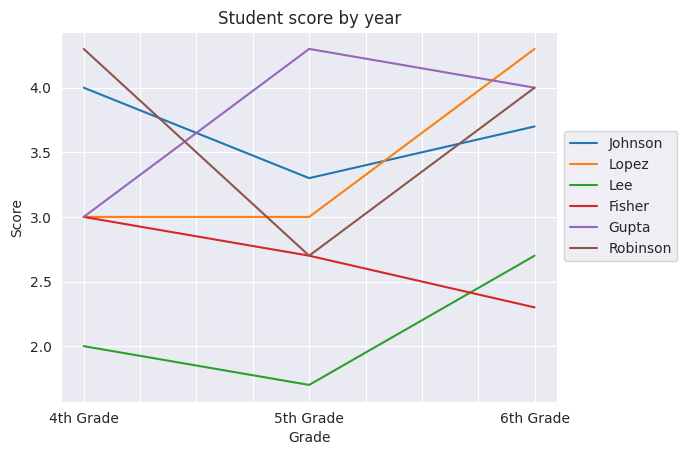

In [21]:
# combine multiple df manipulation calls
(
    students.set_index("Last Name")
    .drop("First Name", axis=1)
    .apply(num_score)
    .T.plot(title="Student score by year", ylabel="Score", xlabel="Grade")
    .legend(bbox_to_anchor=(1, 0.75))
);

### Sanity Checks - Data Format

In the following, we investigate an ill-formatted csv file that cannot be parsed from scratch.

In [22]:
# Use try/except to avoid full traceback in example
try:
    pd.read_csv(os.path.join(data_dir, "big-random.csv"))
except Exception as err:
    print(err)
    traceback.print_exc()

Error tokenizing data. C error: Expected 6 fields in line 13128, saw 8



Traceback (most recent call last):
  File "/tmp/ipykernel_279922/3579138110.py", line 3, in <module>
    pd.read_csv(os.path.join(data_dir, "big-random.csv"))
  File "/home/presenter/.local/share/virtualenvs/data-engineering-analytics-notebooks-HkcVBOzx/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/presenter/.local/share/virtualenvs/data-engineering-analytics-notebooks-HkcVBOzx/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 626, in _read
    return parser.read(nrows)
           ^^^^^^^^^^^^^^^^^^
  File "/home/presenter/.local/share/virtualenvs/data-engineering-analytics-notebooks-HkcVBOzx/lib/python3.12/site-packages/pandas/io/parsers/readers.py", line 1923, in read
    ) = self._engine.read(  # type: ignore[attr-defined]
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/presenter/.local/share/virtualenvs/data-e

In [23]:
%%bash
# Check general size/shape of the file
wc ../data/big-random.csv

 100004  100004 4335846 ../data/big-random.csv


In [24]:
%%bash
# gather number of commas
# tr -d deletes characters, -c inverts the given string to be deleted
# --> deletes anything that is not ,\n
# awk prints number of characters
# uniq -c counts duplicates lines
cat ../data/big-random.csv | 
    tr -d -c ',\n' | 
    awk '{ print length; }' | 
    sort | 
    uniq -c

     54 3
  99909 5
     41 7


In [25]:
%%bash
# Inspect lines not adhering to format (those with seven commas)
# print one context line (-C1), print line number (-n), use posix regex
grep -C1 -nP '([^,]+,){7}' ../data/big-random.csv | head

13127-mayday,10,disinstallavo,46,redimente,70
13128:ammalizio,41,sbellico,89,distornavano,67,pioterebbe,43
13129-ramagliature,24,affumicatoi,42,tambusseremo,23
--
13564-zinconcini,35,dissennammo,52,deviino,76
13565:microcassetta,91,delicatuzzi,43,dissapori,30,sconverreste,50
13566-monastica,27,laparatomici,90,glottodidattica,92
--
13575-nuotate,91,dormicolavano,51,sommante,80
13576:offrirebbe,46,rifiancante,86,triangolano,31,raggiavamo,86


In [26]:
# filter out lines that do adhere to the format
# discard any other lines
pat = re.compile(r"^([^,]+,){5}[^,]*$")
with open(os.path.join(data_dir, "big-random.csv")) as fh:
    lines = [line.strip().split(",") for line in fh if re.match(pat, line)]
pd.DataFrame(lines)

,0,1,2,3,4,5
0,infilaste,21,esemplava,15,stabaccavo,73
1,abbadaste,50,enartrosi,85,iella,54
2,frustulo,77,temporale,83,scoppianti,91
3,gavocciolo,84,postelegrafiche,93,inglesizzanti,63
4,svani,92,spiombasti,99,aderisce,74
...,...,...,...,...,...,...
99904,rattralciassi,12,riflessogeni,65,rinvanghiate,90
99905,notareschi,60,paganico,64,esecutavamo,20
99906,rispranghiamo,11,schioccano,44,imbozzarono,80
99907,compone,85,disfronderebbe,19,vaporizzavo,54


### Common Problems

In [27]:
# Encodings example
# read in movie data
# rt = rottenTomatoes
# encoded in latin1
movies = pd.read_csv(
    os.path.join(data_dir, "hetrec/movies.dat"),
    delimiter="\t",
    na_values=["\\N"],
    encoding="latin1",
)
movies.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10197 non-null  int64  
 1   title                   10197 non-null  object 
 2   imdbID                  10197 non-null  int64  
 3   spanishTitle            10197 non-null  object 
 4   imdbPictureURL          10016 non-null  object 
 5   year                    10197 non-null  int64  
 6   rtID                    9886 non-null   object 
 7   rtAllCriticsRating      9967 non-null   float64
 8   rtAllCriticsNumReviews  9967 non-null   float64
 9   rtAllCriticsNumFresh    9967 non-null   float64
 10  rtAllCriticsNumRotten   9967 non-null   float64
 11  rtAllCriticsScore       9967 non-null   float64
 12  rtTopCriticsRating      9967 non-null   float64
 13  rtTopCriticsNumReviews  9967 non-null   float64
 14  rtTopCriticsNumFresh    9967 non-null 

datatypes cannot be inferred from textual data

In [28]:
%%bash
cat ../data/parts.tsv

Part_No	Description	Date	Price (USD)
12345	Wankle rotary	2020-04-12T15:53:21	555.55
67890	Sousaphone	April 12, 2020	333.33
2468	Feather Duster	4/12/2020	22.22
A9922	Area 51 metal	04/12/20	9999.99


In [29]:
df = pd.read_csv(os.path.join(data_dir, "parts.tsv"), delimiter="\t")
df

,Part_No,Description,Date,Price (USD)
0,12345,Wankle rotary,2020-04-12T15:53:21,555.55
1,67890,Sousaphone,"April 12, 2020",333.33
2,2468,Feather Duster,4/12/2020,22.22
3,A9922,Area 51 metal,04/12/20,9999.99


In [30]:
df.dtypes

Part_No         object
Description     object
Date            object
Price (USD)    float64
dtype: object

In [31]:
# let pandas extract the right date format
df = pd.read_csv(
    os.path.join(data_dir, "parts.tsv"), delimiter="\t")
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df.dtypes

Part_No                object
Description            object
Date           datetime64[ns]
Price (USD)           float64
dtype: object

## JSON

### Parsing Numbers

In [32]:
# An interpreted float, an overflow, and a truncation
json_str = "[1e308, 1e309, 1.2345678901234567890]"
json.loads(json_str)

[1e+308, inf, 1.2345678901234567]

In [33]:
specials = "[NaN, Infinity, -Infinity]"
vals = json.loads(specials)
vals
# improved version
vals = json.loads("[NaN, Infinity, -Infinity]", parse_constant=lambda _: "INVALID")
#json.loads("[NaN, Infinity, test]", parse_constant=lambda _: "INVALID")
vals

[nan, inf, -inf]

['INVALID', 'INVALID', 'INVALID']

### JSON Lines

In [34]:
%%bash
# quick look at json file
# formatting lines to max 55 width
# removing all whitespace
cat -n ../data/jsonlines.log | fmt -w55 | tr -d " "

1	{"ts":"2020-06-18T10:44:13",
"logged_in":{"username":"foo"},
"connection":{"addr":"1.2.3.4","port":5678}}
2	{"ts":"2020-06-18T10:44:15",
"registered":{"username":"bar","email":"bar@example.com"},
"connection":{"addr":"2.3.4.5","port":6789}}
3	{"ts":"2020-06-18T10:44:16",
"logged_out":{"username":"foo"},
"connection":{"addr":"1.2.3.4","port":5678}}
4	{"ts":"2020-06-18T10:47:22",
"registered":{"username":"baz","email":"baz@example.net"},
"connection":{"addr":"3.4.5.6","port":7890}}


In [35]:
%%bash
# Extract registrations
grep "registered" ../data/jsonlines.log |
    sed 's/^.*registered"://' |
    sed 's/}.*/}/'

{"username":"bar","email":"bar@example.com"}
{"username":"baz","email":"baz@example.net"}


In [36]:
%%bash
jq '.registered | select(.username != null)' ../data/jsonlines.log

{
  "username": "bar",
  "email": "bar@example.com"
}
{
  "username": "baz",
  "email": "baz@example.net"
}


In [37]:
with open(os.path.join(data_dir, "jsonlines.log")) as log:
    for line in log:
        record = json.loads(line)
        if "registered" in record:
            user = record["registered"]
            if "username" in user:
                print(user)

{'username': 'bar', 'email': 'bar@example.com'}
{'username': 'baz', 'email': 'baz@example.net'}


## Anomaly Detection

The following examples aim to showcase how to detect data anomalies in different data formats.

### Missing Data: JSON


Example for JSON and dealing with sentinel values (adopted from CleanData).

In [38]:
# create an array with different values - including sentinels
json_data = '{"values": [NaN, 1.23, null, 3.45, 6.78, 9.01, Infinity, "Not a number", "A Number", ""]}'
pd.read_json(io.StringIO(json_data))

,values
0,None
1,1.23
2,None
3,3.45
4,6.78
5,9.01
6,inf
7,Not a number
8,A Number
9,


In [39]:
# check JSON for problems regarding number parsing,
# classify problems (missing, not a number or empty)
data = json.loads(json_data)

for value in data["values"]:
    if value is None:
        print(f"{value}: Missing")
    elif isinstance(value, float) and math.isnan(value):
        print(f"{value}: Not a Number")
    elif not value:
        print(
            f"{value}: Empty value ({repr(value)})"
        )  # return representable string

nan: Not a Number
None: Missing
: Empty value ('')


### Missing Data: CSV

Real world example (from later example in exploratory data analysis notebook)

Example reads movie data, including critics data from rottenTomatoes (rt); data source: hetrec movielens dataset (https://grouplens.org/datasets/hetrec-2011/, dataset readme: https://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt).

In [40]:
movies = pd.read_csv(
    os.path.join(data_dir, "hetrec/movies.dat"),
    delimiter="\t",
    encoding="latin1",
)
movies.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      10197 non-null  int64 
 1   title                   10197 non-null  object
 2   imdbID                  10197 non-null  int64 
 3   spanishTitle            10197 non-null  object
 4   imdbPictureURL          10016 non-null  object
 5   year                    10197 non-null  int64 
 6   rtID                    9886 non-null   object
 7   rtAllCriticsRating      10197 non-null  object
 8   rtAllCriticsNumReviews  10197 non-null  object
 9   rtAllCriticsNumFresh    10197 non-null  object
 10  rtAllCriticsNumRotten   10197 non-null  object
 11  rtAllCriticsScore       10197 non-null  object
 12  rtTopCriticsRating      10197 non-null  object
 13  rtTopCriticsNumReviews  10197 non-null  object
 14  rtTopCriticsNumFresh    10197 non-null  object
 15  rt

In [41]:
# leads to error
#movies["rtAllCriticsRating"].mean()

Looking at the values that need to be read: `\N` is contained often to signal a null value that is not correctly recognized. This can be solved by specifying the utilized na value (provide a list of possible values via `na_values`) when reading the csv file:

In [42]:
# add \\N to missing value fields
movies = pd.read_csv(
    os.path.join(data_dir, "hetrec/movies.dat"),
    delimiter="\t",
    encoding="latin1",
    na_values=["\\N"],
)
movies["rtAllCriticsRating"].mean()

np.float64(5.1392996889736136)

### Missing Data and Sentinel Values

Real-World data from United States National Oceanic and Atmospheric Administration: weather station at Sorstokken, Norway (adopted from CleanData, data source: https://github.com/PacktPublishing/Cleaning-Data-for-Effective-Data-Science/blob/main/data/sorstokken-no.csv.gz). The data was originally taken from the United STates National  Oceanic and Atmospheric Administration (NOAA) website. The original csv file can be found on their data search page (https://www.ncei.noaa.gov/access/search/dataset-search), selecting the year 2019 and Sorstokken, Norway as the location (https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day?startDate=2019-01-01T00:00:00&endDate=2020-02-01T23:59:59&bbox=69.793,-4.656,49.793,15.344). 

Dataset provides information provided by weather sensors (temperature, visibility (distance at which objects can still be seen), wind gusts, dew point).

In [43]:
# read data
sorstokken = pd.read_csv(os.path.join(data_dir, "sorstokken-no.csv.gz"))
sorstokken

,STATION,DATE,TEMP,VISIB,GUST,DEWP
0,1001499999,2019-01-01,39.7,6.2,52.1,30.4
1,1001499999,2019-01-02,36.4,6.2,999.9,29.8
2,1001499999,2019-01-03,36.5,3.3,999.9,35.6
3,1001499999,UNKNOWN,45.6,2.2,22.0,44.8
4,1001499999,2019-01-06,42.5,1.9,999.9,42.5
...,...,...,...,...,...,...
294,1001499999,2019-12-16,39.1,6.2,999.9,36.8
295,1001499999,2019-12-17,40.5,6.2,999.9,39.2
296,1001499999,2019-12-18,38.8,6.2,999.9,38.2
297,1001499999,2019-12-19,45.5,6.1,999.9,42.7


In [44]:
# validity check: minimum maximum for all properties
pd.DataFrame([sorstokken.min(), sorstokken.max()])

,STATION,DATE,TEMP,VISIB,GUST,DEWP
0,1001499999,2019-01-01,27.2,1.2,17.1,16.5
1,1001499999,UNKNOWN,88.1,999.9,999.9,63.5


Visibility and gust of 999.9 can't be correct - value of 999.9 is used as sentinel (bad choice). Let's further look into the following once including and once excluding sentinels via 5-point summary and boxplots:
* max values
* mean values
* standard deviation
* quartiles

In [45]:
# visibility - five point summary incl./excl. sentinel
sorstokken.describe()
sorstokken["VISIB"][sorstokken["VISIB"] < 999.9].describe()

,STATION,TEMP,VISIB,GUST,DEWP
count,2.990000e+02,299.000000,299.000000,299.000000,299.000000
mean,1.001500e+09,49.182609,75.746154,691.704013,41.537793
std,0.000000e+00,10.109699,254.425358,452.407625,10.049763
min,1.001500e+09,27.200000,1.200000,17.100000,16.500000
25%,1.001500e+09,40.750000,6.200000,34.000000,33.900000
50%,1.001500e+09,47.400000,6.200000,999.900000,41.400000
75%,1.001500e+09,57.150000,6.200000,999.900000,49.150000
max,1.001500e+09,88.100000,999.900000,999.900000,63.500000


count    278.000000
mean       5.935971
std        0.672031
min        1.200000
25%        6.100000
50%        6.200000
75%        6.200000
max        6.800000
Name: VISIB, dtype: float64

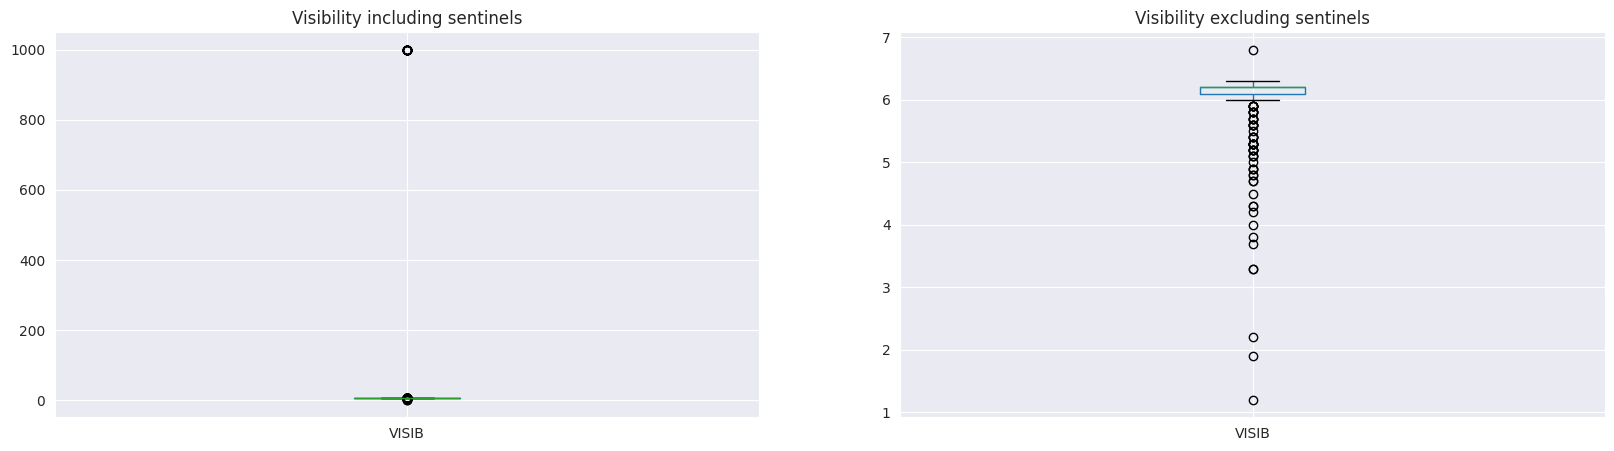

In [46]:
# visibility look at boxplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
pd.DataFrame(sorstokken["VISIB"]).boxplot(ax=axes[0])
axes[0].set_title("Visibility including sentinels")
pd.DataFrame(sorstokken["VISIB"][sorstokken["VISIB"] < 999.9]).boxplot(
    ax=axes[1]
)
axes[1].set_title("Visibility excluding sentinels");

In [47]:
# wind gusts - five point summary incl./excl. sentinel
sorstokken["GUST"].describe()
sorstokken["GUST"][sorstokken["GUST"] < 999.9].describe()

count    299.000000
mean     691.704013
std      452.407625
min       17.100000
25%       34.000000
50%      999.900000
75%      999.900000
max      999.900000
Name: GUST, dtype: float64

count    95.000000
mean     29.893684
std       8.143302
min      17.100000
25%      24.100000
50%      28.900000
75%      32.100000
max      62.200000
Name: GUST, dtype: float64

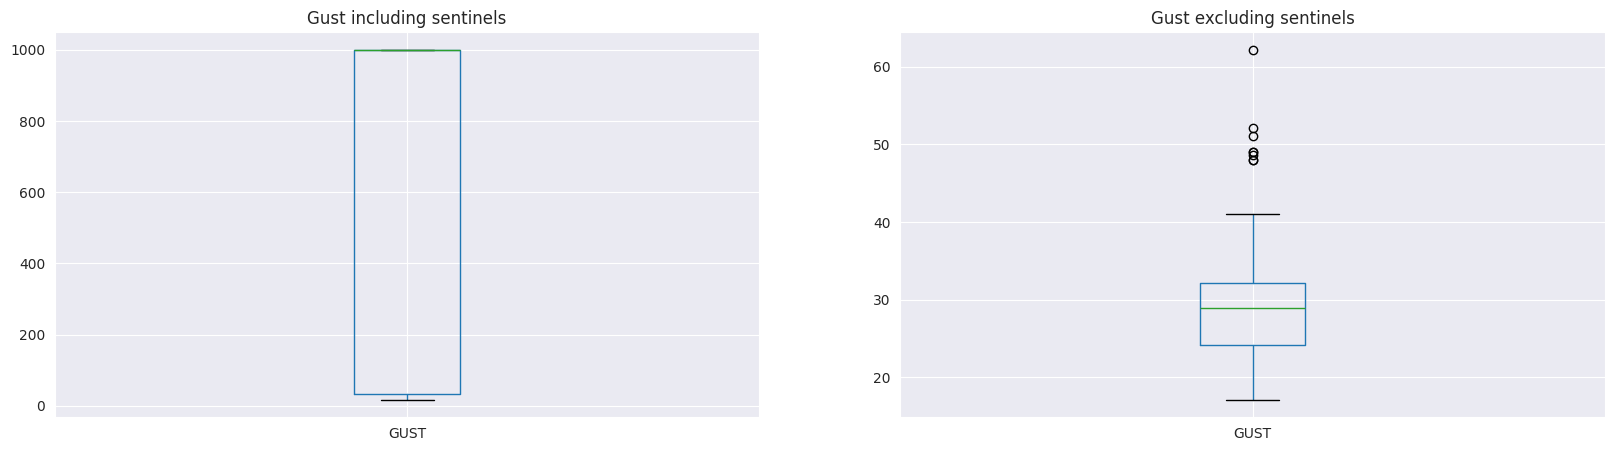

In [48]:
# gust boxplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
pd.DataFrame(sorstokken["GUST"]).boxplot(ax=axes[0])
axes[0].set_title("Gust including sentinels")
pd.DataFrame(sorstokken["GUST"][sorstokken["GUST"] < 999.9]).boxplot(
    ax=axes[1]
)
axes[1].set_title("Gust excluding sentinels");

These analyses show that we need to label values of 999.9 as sentinels (n/a) values, doable via specifying `na_values`).

In [49]:
sorstokken = pd.read_csv(
    os.path.join(data_dir, "../data/sorstokken-no.csv.gz"),
    na_values={"DATE": "UNKNOWN", "VISIB": "999.9", "GUST": "999.9"},
    parse_dates=["DATE"],
)

In [50]:
sorstokken.head()

,STATION,DATE,TEMP,VISIB,GUST,DEWP
0,1001499999,2019-01-01,39.7,6.2,52.1,30.4
1,1001499999,2019-01-02,36.4,6.2,NaN,29.8
2,1001499999,2019-01-03,36.5,3.3,NaN,35.6
3,1001499999,NaT,45.6,2.2,22.0,44.8
4,1001499999,2019-01-06,42.5,1.9,NaN,42.5


### Miscoded Data

#### Ordinals

Miscoded data: for ordinals, we need to check minimum, maximum and whether data type is integer; adopted from CleanData. The dataset includes ordinals (values 0, 1, 2, 3 to describe the extent to which a feature is present).

The following code reads clinical data; the primary goal was to determine the type of Eryhemato-Squamous Disease. The dataset features clinical attributes (e.g., age or family history) and histopathological atributes.
The data was taken from the UC Irvine Machine Learning Repository (https://archive-beta.ics.uci.edu/): https://archive-beta.ics.uci.edu/ml/datasets/dermatology.

In [51]:
# metadata for dataset
# Histopathological Attributes: (values 0, 1, 2, 3;
# 0 being feature not present, 3 feature present to largest amount possible)
# Clinical Attributes: (values 0, 1, 2, 3, unless indicated)
features = [
    "erythema",
    "scaling",
    "definite borders",
    "itching",
    "koebner phenomenon",
    "polygonal papules",
    "follicular papules",
    "oral mucosal involvement",
    "knee and elbow involvement",
    "scalp involvement",
    "family history",  # 0 or 1
    "melanin incontinence",
    "eosinophils in the infiltrate",
    "PNL infiltrate",
    "fibrosis of the papillary dermis",
    "exocytosis",
    "acanthosis",
    "hyperkeratosis",
    "parakeratosis",
    "clubbing of the rete ridges",
    "elongation of the rete ridges",
    "thinning of the suprapapillary epidermis",
    "spongiform pustule",
    "munro microabcess",
    "focal hypergranulosis",
    "disappearance of the granular layer",
    "vacuolisation and damage of basal layer",
    "spongiosis",
    "saw-tooth appearance of retes",
    "follicular horn plug",
    "perifollicular parakeratosis",
    "inflammatory monoluclear inflitrate",
    "band-like infiltrate",
    "Age",  # linear; missing marked '?'
    "TARGET",  # See mapping
]

targets = {
    1: "psoriasis",  # 112 instances
    2: "seboreic dermatitis",  # 61
    3: "lichen planus",  # 72
    4: "pityriasis rosea",  # 49
    5: "cronic dermatitis",  # 52
    6: "pityriasis rubra pilaris",  # 20
}

In [52]:
# read data
np.random.seed(1)
data = os.path.join(data_dir, "dermatology.data")
#metadata = os.path.join(data_dir, "dermatology.names")
df = pd.read_csv(data, header=None, names=features)
# map target values to labels according to defined mapping (1: psoriasis)
df["TARGET"] = df.TARGET.map(targets)

derm = df.copy()
derm.loc[derm.Age == "?", "Age"] = None
derm["Age"] = derm.Age.astype(float)

In [53]:
# first glimpse at data
derm

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,TARGET
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55.0,seboreic dermatitis
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8.0,psoriasis
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26.0,lichen planus
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40.0,psoriasis
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45.0,lichen planus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0,25.0,pityriasis rosea
362,3,2,1,0,1,0,0,0,0,0,...,1,0,1,0,0,0,2,0,36.0,pityriasis rosea
363,3,2,2,2,3,2,0,2,0,0,...,0,3,0,3,0,0,2,3,28.0,lichen planus
364,2,1,3,1,2,3,0,2,0,0,...,0,2,0,1,0,0,2,3,50.0,lichen planus


In [54]:
# check min and max values and datatype for each column
derm.min()

erythema                                                    0
scaling                                                     0
definite borders                                            0
itching                                                     0
koebner phenomenon                                          0
polygonal papules                                           0
follicular papules                                          0
oral mucosal involvement                                    0
knee and elbow involvement                                  0
scalp involvement                                           0
family history                                              0
melanin incontinence                                        0
eosinophils in the infiltrate                               0
PNL infiltrate                                              0
fibrosis of the papillary dermis                            0
exocytosis                                                  0
acanthos

In [55]:
derm.max()

erythema                                                      3
scaling                                                       3
definite borders                                              3
itching                                                       3
koebner phenomenon                                            3
polygonal papules                                             3
follicular papules                                            3
oral mucosal involvement                                      3
knee and elbow involvement                                    3
scalp involvement                                             3
family history                                                1
melanin incontinence                                          3
eosinophils in the infiltrate                                 2
PNL infiltrate                                                3
fibrosis of the papillary dermis                              3
exocytosis                              

In [56]:
derm.dtypes

erythema                                      int64
scaling                                       int64
definite borders                              int64
itching                                       int64
koebner phenomenon                            int64
polygonal papules                             int64
follicular papules                            int64
oral mucosal involvement                      int64
knee and elbow involvement                    int64
scalp involvement                             int64
family history                                int64
melanin incontinence                          int64
eosinophils in the infiltrate                 int64
PNL infiltrate                                int64
fibrosis of the papillary dermis              int64
exocytosis                                    int64
acanthosis                                    int64
hyperkeratosis                                int64
parakeratosis                                 int64
clubbing of 

The minimum and maximum values of ordinals are correct, it seems that there is no miscoded data contained. Furthermore, the data types are all integers. 

#### Categorical Data

The following example shows how categorical data can be inspected, validated, and corrected (if necessary) w.r.t. issues with the categories given. The dataset is taken from the CleanData book (dataset available via https://github.com/PacktPublishing/Cleaning-Data-for-Effective-Data-Science/blob/main/data/humans-err.csv), initially synthetically created from the author.

In [57]:
humans = pd.read_csv(os.path.join(data_dir, "humans-err.csv"))

In [58]:
# look at sample
humans.sample(20, random_state=1)

,Height,Weight,Hair_Length,Favorite
21492,176.958650,72.604585,14.0,red
9488,169.000221,79.559843,0.0,blue
16933,171.104306,71.125528,5.5,red
12604,174.481084,79.496237,8.1,blue
8222,171.275578,77.094118,14.6,green
9110,164.631065,70.557834,25.9,green
21196,171.989674,73.962050,9.2,blue
17193,176.560404,80.627266,87.7,blue
23846,173.640191,82.887089,2.3,blue
10415,171.658356,61.822810,12.5,green


In [59]:
# observe unique values
humans.Favorite.unique()

array(['red', 'green', 'blue', 'Red', ' red', 'grееn', 'blüe',
       'chartreuse'], dtype=object)

In [60]:
# how rare are such variations?
humans.Favorite.value_counts()

Favorite
red           9576
blue          7961
green         7458
Red              1
 red             1
grееn            1
blüe             1
chartreuse       1
Name: count, dtype: int64

We have seen that some variants are very rare, which might be a hint that they are miscoded.

In [61]:
# look at labels more closely, inspect individual characters
# ord returns an integer representing the given unicode character
for color in sorted(humans.Favorite.unique()):
    print(f"{color:10}", [ord(c) for c in color])

 red       [32, 114, 101, 100]
Red        [82, 101, 100]
blue       [98, 108, 117, 101]
blüe       [98, 108, 252, 101]
chartreuse [99, 104, 97, 114, 116, 114, 101, 117, 115, 101]
green      [103, 114, 101, 101, 110]
grееn      [103, 114, 1077, 1077, 110]
red        [114, 101, 100]


In [62]:
# transform troublesome values
humans.loc[humans.Favorite.isin(["Red", " red"]), "Favorite"] = "red"
humans.loc[humans.Favorite == "chartreuse", "Favorite"] = None
humans.loc[humans.Favorite == "blüe", "Favorite"] = "blue"
humans.loc[humans.Favorite == "grееn", "Favorite"] = "green"
humans.Favorite.value_counts()

Favorite
red      9578
blue     7962
green    7459
Name: count, dtype: int64

### Fixed Bounds

Continues previous example of humans, adapted from CleanData. Now we use fixed bounds to find any values that exceed those bounds, this should give us some hints w.r.t. erroneous values.

In [63]:
# any humans exceeding the given bounds for height?
((humans.Height < 92) | (humans.Height > 213)).any()

np.False_

In [64]:
# any humans exceeding the given bounds for hair length?
(humans.Hair_Length > 120).any()

np.True_

In [65]:
# find those values
humans.query("Hair_Length > 120")

,Height,Weight,Hair_Length,Favorite
1984,165.634695,62.979993,127.0,red
8929,175.186061,73.899992,120.6,blue
14673,174.948037,77.644434,130.1,blue
14735,176.385525,68.735397,121.7,green
16672,173.172298,71.814699,121.4,red
17093,169.771111,77.958278,133.2,blue


Our solution for this is to fix (clip) all values > 120 to 120, which we consider the maximum value.

In [66]:
# clip hair length at 120 and check
humans["Hair_Length"] = humans.Hair_Length.clip(upper=120)
humans[humans.Hair_Length > 119]

,Height,Weight,Hair_Length,Favorite
1984,165.634695,62.979993,120.0,red
4146,173.930107,72.701456,119.6,red
8929,175.186061,73.899992,120.0,blue
9259,179.215974,82.538890,119.4,green
14673,174.948037,77.644434,120.0,blue
14735,176.385525,68.735397,120.0,green
16672,173.172298,71.814699,120.0,red
17093,169.771111,77.958278,120.0,blue


In [67]:
# other extreme case: hair length of 0
humans[humans.Hair_Length == 0]

,Height,Weight,Hair_Length,Favorite
6,177.297182,81.153493,0.0,blue
217,171.893967,68.553526,0.0,blue
240,161.862237,76.914599,0.0,blue
354,172.972247,73.175032,0.0,red
371,179.866011,80.418554,0.0,red
...,...,...,...,...
24818,171.537554,72.619095,0.0,green
24834,170.991301,67.652660,0.0,green
24892,177.002643,77.286141,0.0,green
24919,169.012286,74.593809,0.0,blue


In [68]:
# or even more extreme (and wrong): negative hair lengths
neg_hair = humans[humans.Hair_Length < 0]
neg_hair

,Height,Weight,Hair_Length,Favorite
493,167.703398,72.567763,-1.0,blue
528,167.355393,60.276190,-20.7,green
562,172.416114,60.867457,-68.1,green
569,177.644146,74.027147,-5.9,green
738,178.094818,76.963924,-57.2,blue
...,...,...,...,...
24042,174.608922,64.846422,-22.7,green
24055,172.831608,74.096660,-13.3,red
24063,172.687488,69.466838,-14.2,green
24386,176.668430,62.984811,-1.0,green


In [69]:
# look at distribution of negative hair lengths
neg_hair.Hair_Length.describe()

count    118.000000
mean     -24.348305
std       22.484691
min      -95.700000
25%      -38.075000
50%      -20.650000
75%       -5.600000
max       -0.700000
Name: Hair_Length, dtype: float64

In [70]:
# look at distribution of positive hair lengths
pos_hair = humans[humans.Hair_Length > 0]
pos_hair.Hair_Length.describe()

count    24365.000000
mean        26.675485
std         21.206516
min          0.100000
25%          9.900000
50%         21.700000
75%         38.400000
max        120.000000
Name: Hair_Length, dtype: float64

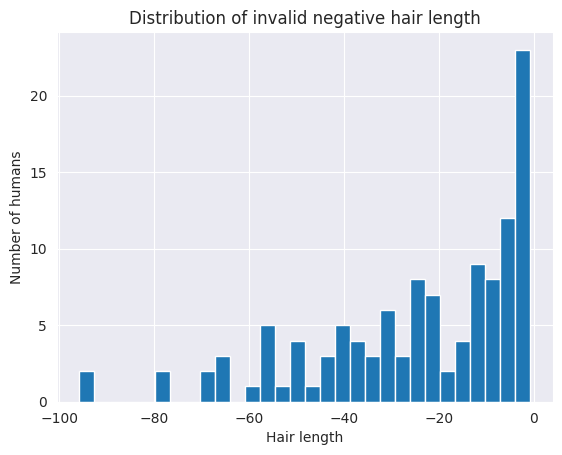

In [71]:
# histogram of negative hair length
sns.set_style("darkgrid")
plt.hist(neg_hair.Hair_Length, bins=30)
plt.title("Distribution of invalid negative hair length")
plt.xlabel("Hair length")
plt.ylabel("Number of humans");

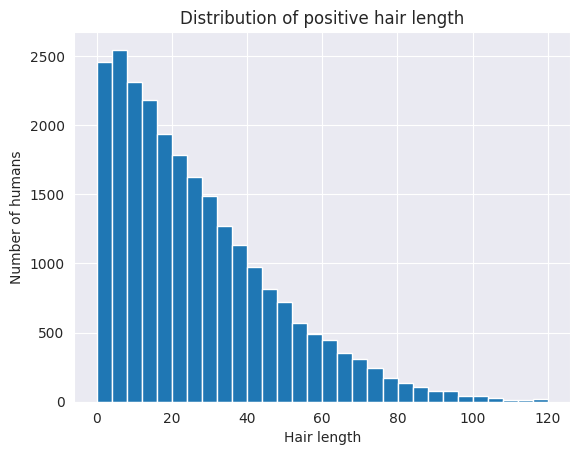

In [72]:
# histogram of positive hair length
plt.hist(pos_hair.Hair_Length, bins=30)
plt.title("Distribution of positive hair length")
plt.xlabel("Hair length")
plt.ylabel("Number of humans");

In [73]:
# how often does each negative hair length occur?
neg_hair.Hair_Length.value_counts()

Hair_Length
-1.0     19
-41.6     2
-5.2      2
-8.5      2
-21.4     2
         ..
-48.5     1
-22.7     1
-13.3     1
-14.2     1
-24.4     1
Name: count, Length: 93, dtype: int64

Given the previous analyses, we can assume that -1 is a sentinel value for unknown hair length. For all other values, we might (based on domain knowledge, for instance, regarding the data input procedure, assume that they were erroneously "turned" negative), this is also supported by the fact that the distributions of positive and negative hair lengths are similar. Naturally, an alternative would be to drop all hair lengths of < 0.

In [74]:
# The "sentinel" negative value means missing
humans.loc[humans.Hair_Length == -1, "Hair_Length"] = None

In [75]:
# All other values simply become non-negative
humans["Hair_Length"] = humans.Hair_Length.abs()

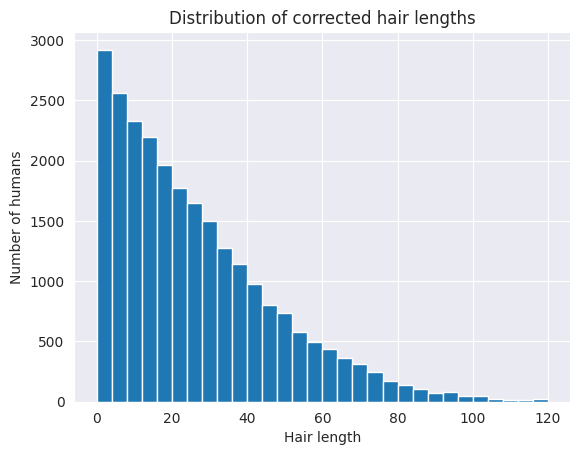

In [76]:
# plot final distribution of hair length
plt.hist(humans.Hair_Length, bins=30)
plt.title("Distribution of corrected hair lengths")
plt.xlabel("Hair length")
plt.ylabel("Number of humans");

### Outlier Detection

In the following, we will showcase different outlier detection methods. We will apply those to the same dataset to be able to compare the results.

#### Z-Score

The following example shows the use of z-scores for outlier detection. The first step is to test for normal distribution. Here, we show four different methods to test for normal distribution.

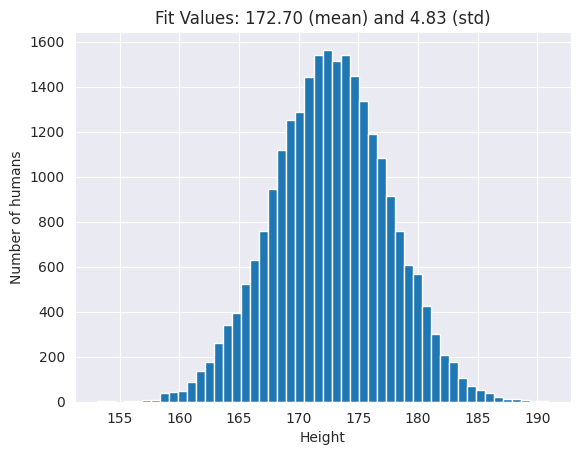

In [77]:
# test for normal distribution: plotting a histogram

# fit normal distribution -> compute mean and std
mean, std = norm.fit(humans.Height)
plt.hist(humans.Height, bins=50)
title = "Fit Values: {:.2f} (mean) and {:.2f} (std)".format(mean, std)
plt.xlabel("Height")
plt.ylabel("Number of humans")
plt.title(title);

<Axes: >

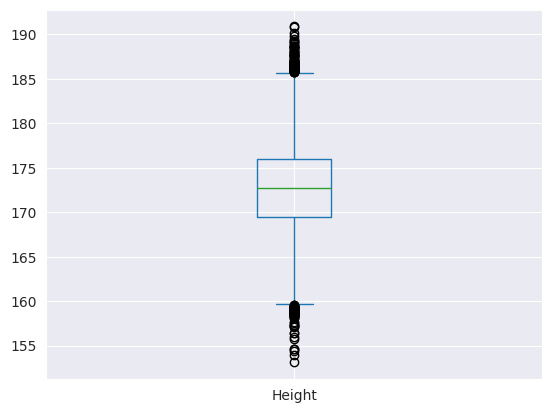

In [78]:
# test for normal distribution: plot boxplot (in this case, via pandas)
humans.Height.plot(kind="box")

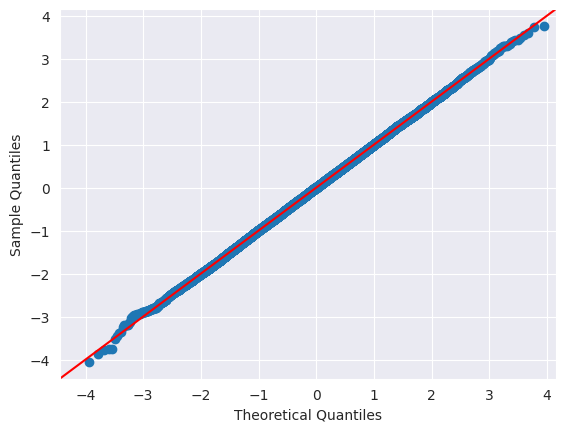

In [79]:
# test for normal distribution: QQ plot
# per default compares given data to normal distribution
sm.qqplot(humans.Height, line="45", fit=True);

In [80]:
# Kolmogorov-Smirnov test
# null hypothesis: no difference between the two distributions
ks_statistic, p_value = kstest(humans.Height, "norm")
ks_statistic, p_value

(np.float64(1.0), np.float64(0.0))

Those tests show that the distribution indeed follows a normal distribution, hence, we can apply z-scores for outlier detection.

In [81]:
# compute z-scores for three column heigh, weight, hair length
for var in ("Height", "Weight", "Hair_Length"):
    zscore = (humans[var] - humans[var].mean()) / humans[var].std()
    humans[f"zscore_{var}"] = zscore

In [82]:
# check new structure of dataframe
humans.columns

Index(['Height', 'Weight', 'Hair_Length', 'Favorite', 'zscore_Height',
       'zscore_Weight', 'zscore_Hair_Length'],
      dtype='object')

In [83]:
# which columns feature outliers w.r.t. height?
humans[humans.zscore_Height.abs() > 3]

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
138,187.708718,86.829633,19.3,green,3.105616,2.084216,-0.320304
174,187.537446,79.893761,37.5,blue,3.070170,1.047496,0.532971
412,157.522316,62.564977,6.8,blue,-3.141625,-1.542673,-0.906345
1162,188.592435,86.155948,53.1,red,3.288506,1.983518,1.264351
1383,188.454995,74.021469,13.6,green,3.260062,0.169753,-0.587539
1893,190.888112,84.293878,15.4,green,3.763609,1.705191,-0.503149
2395,187.948545,81.960413,19.7,green,3.155250,1.356403,-0.301551
2481,190.792583,88.300717,15.5,blue,3.743839,2.304102,-0.498461
2651,153.956131,50.498554,34.2,red,-3.879666,-3.346266,0.378257
3696,157.209236,54.914267,10.5,red,-3.206419,-2.686240,-0.732877


To get some intution about how many outliers to expect, we use the 68-99-99.5 rule.

In [84]:
# total observations
len(humans)

25000

In [85]:
# 68-95-99.7 rule -> we'd expect 75 observations beyond 3*std
len(humans) * 0.003

75.0

In [86]:
# look at number of outliers. Note that hair length is single-tailed -
# which means that we expect twice as many outliers.
print(f"Outliers height: {(humans.zscore_Height.abs() > 3).sum()}")
print(f"Outliers weight: {(humans.zscore_Weight.abs() > 3).sum()}")
print(f"Outliers hair length: {(humans.zscore_Hair_Length.abs() > 3.5).sum()}")

Outliers height: 51
Outliers weight: 67
Outliers hair length: 106


In [87]:
# based on our sample size (25,000 samples),
# we might consider setting the z-score threshold higher
# (e.g., to 4 for two-tailed and 4.5 for single-tailed distributions).
# compute combined condition for height, weight, hair length
outlier_condition = (
    (humans.zscore_Height.abs() > 4)
    | (humans.zscore_Weight.abs() > 4)
    | (humans.zscore_Hair_Length.abs() > 4.5)
)
humans[outlier_condition]

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
13971,153.107034,63.155154,4.4,green,-4.055392,-1.454458,-1.018865
14106,157.244415,45.062151,70.7,red,-3.199138,-4.158856,2.089496
22945,157.293031,44.744929,18.4,red,-3.189077,-4.206272,-0.362499


Given this z-score analysis, we would remove those three outliers from the dataset.

#### Inter-quartile Range

The following example uses inter-quartile range for outlier detection.

In [88]:
# function creates boxplots for each column specified
def show_boxplots(df, columns, iqr_multiplier=1.5):
    # Create as many horizontal plots as we have columns
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 2 * len(columns)))
    # For each one, plot the non-null data inside it
    for n, column in enumerate(columns):
        data = df[column][df[column].notnull()]
        axes[n].set_title(f"{column} Distribution")
        # Extend whiskers to specified IQR multiplier
        axes[n].boxplot(
            data, whis=iqr_multiplier, vert=False, sym="x", meanline=True
        )
        axes[n].set_yticks([])
    # Fix spacing of subplots at the end
    fig.tight_layout()

Inspect different IQR multipliers in boxplots:

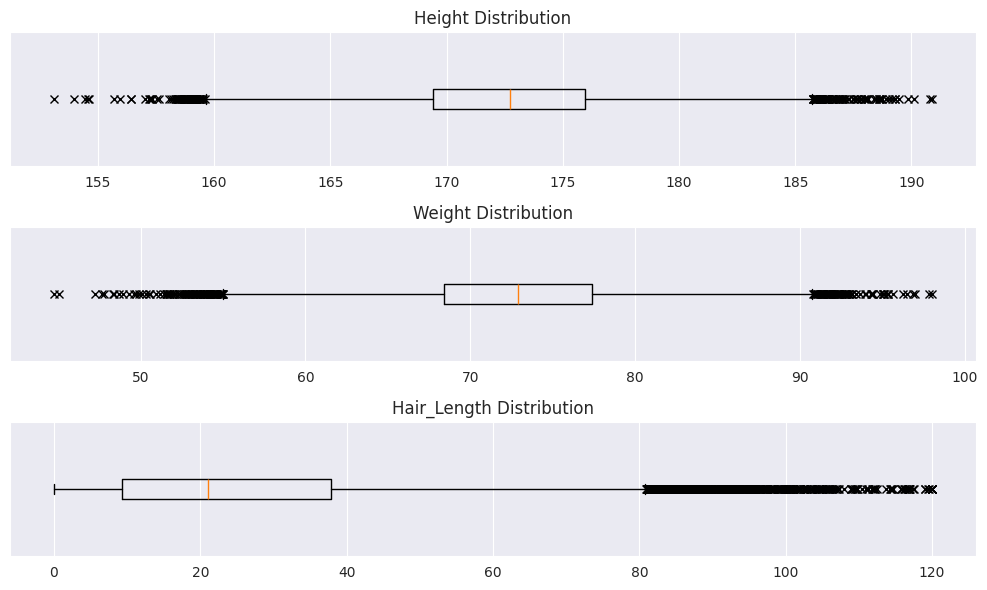

In [89]:
show_boxplots(humans, ["Height", "Weight", "Hair_Length"], 1.5)

In [90]:
# compute quartiles
quartiles = humans[["Height", "Weight", "Hair_Length"]].quantile(
    q=[0.25, 0.50, 0.75, 1.0]
)
quartiles

,Height,Weight,Hair_Length
0.25,169.428884,68.428823,9.3
0.50,172.709078,72.930616,21.1
0.75,175.953541,77.367039,37.9
1.00,190.888112,98.032504,120.0


In [91]:
# compute IQR
IQR = quartiles.loc[0.75] - quartiles.loc[0.25]
IQR

Height          6.524657
Weight          8.938216
Hair_Length    28.600000
dtype: float64

In [92]:
# compute range for inliers
for column, length in IQR.items():
    high = quartiles.loc[0.75, column] + 2.5 * IQR[column]
    low = quartiles.loc[0.25, column] - 2.5 * IQR[column]
    print(f"Inliers for {column}: [{low:.3f}, {high:.3f}]")

Inliers for Height: [153.117, 192.265]
Inliers for Weight: [46.083, 99.713]
Inliers for Hair_Length: [-62.200, 109.400]


In [93]:
# compute combined condition for height, weight, hair length
outlier_condition = (
    (humans.Height > 192.265)
    | (humans.Height < 153.117)
    | (humans.Weight > 99.713)
    | (humans.Weight < 46.083)
    | (humans.Hair_Length < -62.200)
    | (humans.Hair_Length > 109.400)
)
humans[outlier_condition]

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
200,166.958264,69.685473,112.2,blue,-1.188804,-0.478357,4.035152
832,172.132574,81.913727,111.3,blue,-0.117952,1.349425,3.992957
1017,173.938514,75.065606,115.7,red,0.255797,0.325822,4.199244
1984,165.634695,62.979993,120.0,red,-1.462724,-1.480639,4.400842
2008,185.001230,85.343522,114.5,red,2.545287,1.862084,4.142984
3031,180.890647,73.429399,109.5,red,1.694579,0.081255,3.908568
3601,177.577090,77.813630,110.4,red,1.008820,0.736575,3.950762
4146,173.930107,72.701456,119.6,red,0.254057,-0.027552,4.382089
4220,178.222758,77.233031,116.3,green,1.142445,0.649792,4.227374
5366,169.273652,49.888039,111.9,red,-0.709622,-3.437521,4.021087


Based on these analysis, we would remove those 48 rows from the dataset.

#### Absolute Deviation around Median

The following example use absolute deviation around median for outlier detection.

In [94]:
# compute median absolute deviation
# for hair length, we have na values contained, omit those for computation
median_abs_deviation(humans.Weight)
median_abs_deviation(humans.Height)
median_abs_deviation(humans.Hair_Length, nan_policy="omit")

np.float64(4.46943080294767)

np.float64(3.2618807000000345)

np.float64(13.500000000000002)

In [95]:
humans.Hair_Length.isna().any()

np.True_

In [96]:
# compute inlier ranges for each column
def compute_inlier_ranges(data, columns, multiplier):
    ranges = {}
    for column in columns:
        mad = median_abs_deviation(humans[var], nan_policy="omit")
        lower, upper = (
            humans[column].median() - multiplier * mad,
            humans[column].median() + multiplier * mad,
        )
        ranges[column] = (lower, upper)
    return ranges

In [97]:
ranges = compute_inlier_ranges(humans, ["Height", "Weight", "Hair_Length"], 3)
ranges

{'Height': (np.float64(132.20907799999998), np.float64(213.20907799999998)),
 'Weight': (np.float64(32.430615988594106), np.float64(113.43061598859413)),
 'Hair_Length': (np.float64(-19.400000000000006),
  np.float64(61.60000000000001))}

In [98]:
# compute combined condition for height, weight, hair length
outlier_condition = (
    (humans.Height < ranges["Height"][0])
    | (humans.Height > ranges["Height"][1])
    | (humans.Weight < ranges["Weight"][0])
    | (humans.Weight > ranges["Weight"][1])
    | (humans.Hair_Length < ranges["Hair_Length"][0])
    | (humans.Hair_Length > ranges["Hair_Length"][1])
)

humans[outlier_condition]

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
0,167.089607,64.806216,71.1,red,-1.161622,-1.207670,2.108250
2,176.272800,87.767722,77.1,green,0.738890,2.224434,2.389549
3,173.270164,81.635672,97.2,green,0.117478,1.307864,3.331903
4,172.181037,82.760794,67.2,blue,-0.107922,1.476038,1.925405
19,170.513197,71.145258,99.5,red,-0.453091,-0.260160,3.439735
...,...,...,...,...,...,...,...
24952,172.159574,70.383305,62.2,red,-0.112364,-0.374051,1.690988
24966,167.846451,74.738342,62.0,blue,-1.004989,0.276905,1.681612
24986,174.784791,69.294258,62.4,green,0.430939,-0.536833,1.700365
24995,176.535461,67.696134,66.9,green,0.793249,-0.775708,1.911340


This analysis leads to a total of 1902 outliers. Hence, we might consider increasing the number of MAD around the median.

## Data Quality

### Missing Data

The following example uses a dataset of persons with names, ages, genders and favorite flowers and colors, example adopted from CleanData. The data was synthetically created by the author of CleanData and is available at https://github.com/PacktPublishing/Cleaning-Data-for-Effective-Data-Science/blob/main/data/usa_names.parq.

In [99]:
# read parquet file
# Apache Hadoop ecosystem, column-wise format with compression
df = pd.read_parquet(os.path.join(data_dir, "usa_names.parq"))
df

,Age,Gender,Name,Favorite_Color,Favorite_Flower
0,48,F,Lisa,Yellow,Daisy
1,62,F,Karen,Green,Rose
2,26,M,Michael,Purple,None
3,73,F,Patricia,Red,Orchid
4,13,F,Ava,Green,Violet
...,...,...,...,...,...
6337,36,M,Michael,None,Violet
6338,11,M,Jacob,Red,Lily
6339,20,M,Jacob,Green,Rose
6340,72,M,Robert,Blue,Lily


In [100]:
df.describe(include="all")

,Age,Gender,Name,Favorite_Color,Favorite_Flower
count,6342.000000,6342,6342,5599,5574
unique,NaN,2,69,6,5
top,NaN,F,Michael,Yellow,Orchid
freq,NaN,3190,535,965,1356
mean,42.458846,NaN,NaN,NaN,NaN
std,27.312662,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN,NaN
25%,19.000000,NaN,NaN,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN
75%,63.000000,NaN,NaN,NaN,NaN


In [101]:
# roughly 10% are NaN -> could be discarded or imputed
df["Favorite_Flower"].isna().sum()
df["Favorite_Color"].isna().sum()

np.int64(768)

np.int64(743)

We inspect the characteristics of rows with missing flower or color preference - to which extent is the dataset changed if those are removed?

In [102]:
# we copy the values here to avoid chaining assignments
# and working on a view of the original data
missing_flower_preference = df.loc[df["Favorite_Flower"].isna()].copy()
missing_flower_preference.describe()

,Age
count,768.000000
mean,25.350260
std,2.905908
min,21.000000
25%,23.000000
50%,25.000000
75%,28.000000
max,30.000000


In [103]:
# same for color
missing_color_preference = df.loc[df["Favorite_Color"].isna()].copy()
missing_color_preference.describe()

,Age
count,743.000000
mean,35.401077
std,2.869695
min,31.000000
25%,33.000000
50%,35.000000
75%,38.000000
max,40.000000


We now look at the value distributions of the original data and subsequently, the rows with missing values for flower and color.

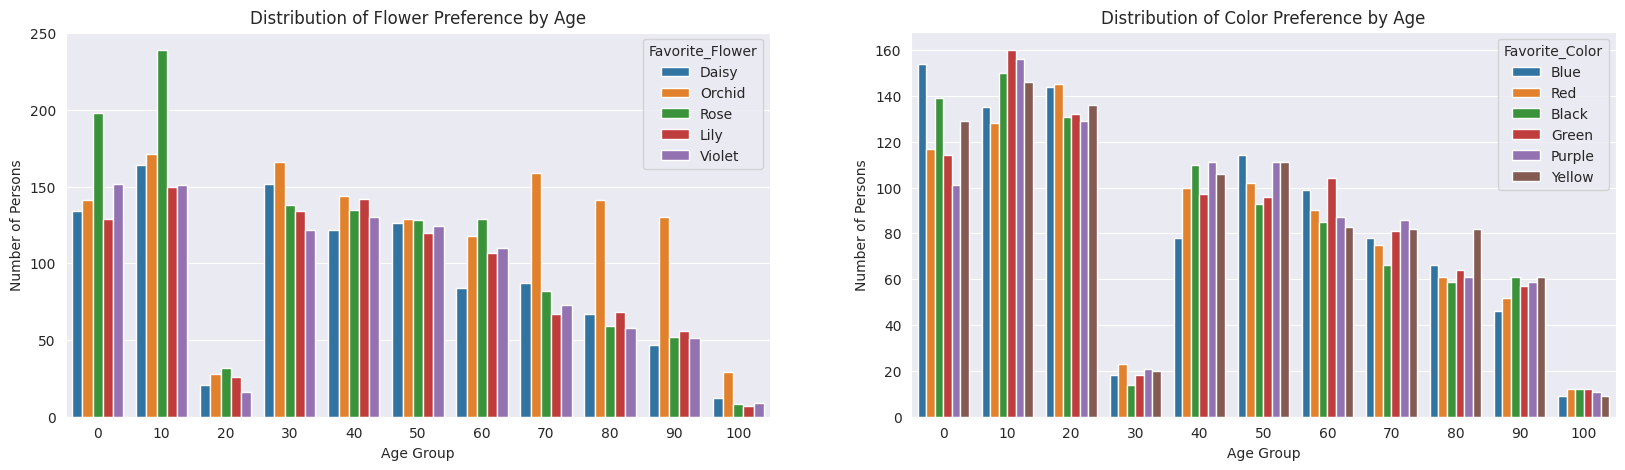

In [104]:
# check distribution of data
df["Age Group"] = df.Age // 10 * 10
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(
    x="Age Group", hue="Favorite_Flower", ax=axes[0], palette="tab10", data=df
)
axes[0].set_title("Distribution of Flower Preference by Age")
axes[0].set_ylabel("Number of Persons")

sns.countplot(
    x="Age Group", hue="Favorite_Color", ax=axes[1], palette="tab10", data=df
)
axes[1].set_title("Distribution of Color Preference by Age")
axes[1].set_ylabel("Number of Persons");

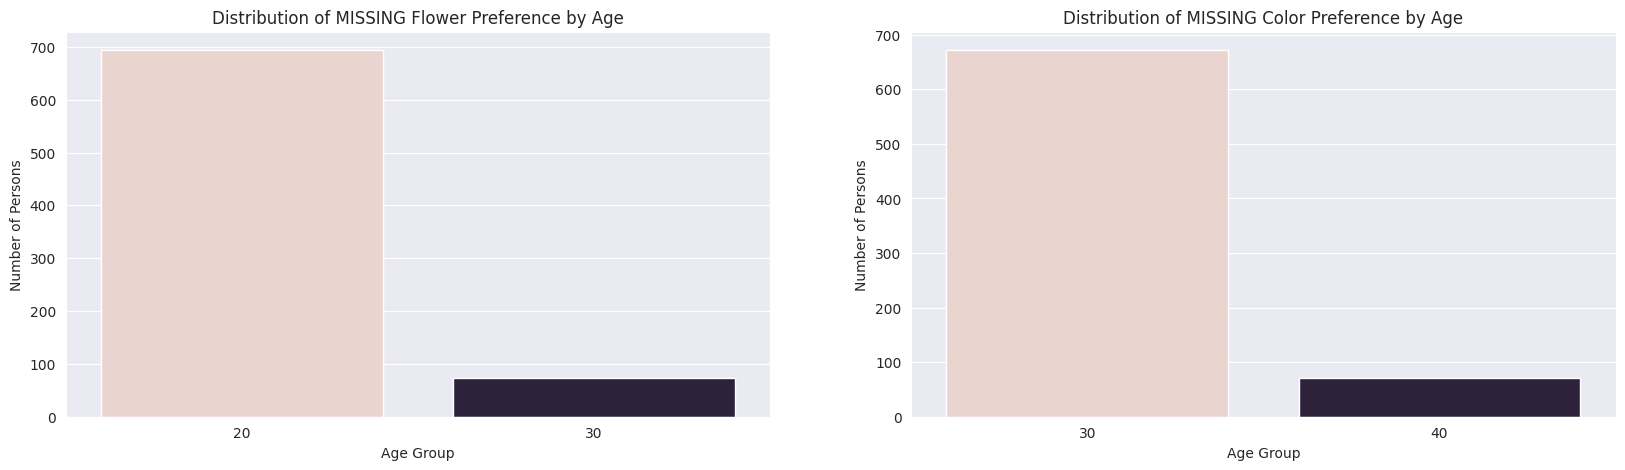

In [105]:
# check distribution of missing data
missing_flower_preference["Age Group"] = df.Age // 10 * 10
missing_color_preference["Age Group"] = df.Age // 10 * 10

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(
    x="Age Group", ax=axes[0], hue="Age Group", legend=False, data=missing_flower_preference
)
axes[0].set_title("Distribution of MISSING Flower Preference by Age")
axes[0].set_ylabel("Number of Persons")

sns.countplot(
    x="Age Group", ax=axes[1], hue="Age Group", legend=False,  data=missing_color_preference
)
axes[1].set_title("Distribution of MISSING Color Preference by Age")
axes[1].set_ylabel("Number of Persons");

These results show us that the distribution of the data to be removed is not similar to the distribution of the original dataset. Dropping all records with missing flower or color preference would mean that there would be hardly any records for this age group (20-40) left, given that it is already sparsely populated in general in this dataset. If age is important for the analysis to be conducted, we might not be able to drop it. However, we will have to carefully use this data and deal with e.g., data imbalance. If age does not impact (or is not featured in the analysis to be performed), then we might simply go on.

### Biasing Trends

In the following, we will investigate bias based on a synthetic dataset of US name/age data, adapted from CleanData. In this case, we look at trends regarding the names of people across different age groups. The state-distribution of names data was synthetically created by the author of CleanData and is available here: https://github.com/PacktPublishing/Cleaning-Data-for-Effective-Data-Science/blob/main/data/usa_names_states.parq)


In [106]:
names = pd.read_parquet(os.path.join(data_dir, "usa_names_states.parq"))
names

,Age,Birth_Month,Name,Gender,Home
0,17,June,Matthew,M,Hawaii
1,5,September,Emma,F,West Virginia
2,4,January,Liam,M,Alaska
3,96,March,William,M,Arkansas
4,7,March,William,M,Hawaii
...,...,...,...,...,...
6337,88,July,Dorothy,F,Massachusetts
6338,29,August,Jessica,F,Massachusetts
6339,51,April,Michael,M,Wyoming
6340,29,May,Christopher,M,North Carolina


In [107]:
# transform age to age groups
names["Age_Group"] = names.Age // 10 * 10
names

,Age,Birth_Month,Name,Gender,Home,Age_Group
0,17,June,Matthew,M,Hawaii,10
1,5,September,Emma,F,West Virginia,0
2,4,January,Liam,M,Alaska,0
3,96,March,William,M,Arkansas,90
4,7,March,William,M,Hawaii,0
...,...,...,...,...,...,...
6337,88,July,Dorothy,F,Massachusetts,80
6338,29,August,Jessica,F,Massachusetts,20
6339,51,April,Michael,M,Wyoming,50
6340,29,May,Christopher,M,North Carolina,20


In [108]:
# find top male names
names[names.Gender == "M"]["Name"].value_counts()

Name
Michael        535
James          348
John           253
Robert         250
Christopher    226
David          223
Jacob          216
Matthew        203
Joshua         189
William        174
Noah            86
Ethan           78
Jason           76
Liam            60
Richard         57
Mason           56
Charles         22
Andrew          21
Daniel          18
Jayden          15
Tyler           12
Oliver           9
Nicholas         8
Logan            8
Alexander        6
Charle           3
Name: count, dtype: int64

In [109]:
# find top female names
names[names.Gender == "F"]["Name"].value_counts()

Name
Mary        272
Jessica     188
Emma        182
Jennifer    169
Ashley      162
Emily       156
Sarah       128
Linda       126
Olivia      123
Isabella    118
Amanda      105
Ava         104
Sophia       95
Lisa         92
Barbara      91
Susan        88
Patricia     88
Melissa      69
Hannah       69
Madison      64
Amy          64
Betty        60
Dorothy      59
Michelle     59
Karen        53
Kimberly     51
Samantha     49
Helen        41
Margaret     34
Brittany     33
Deborah      30
Heather      29
Shirley      23
Alexis       22
Carol        21
Debra        18
Angela       13
Ruth         10
Abigail       9
Donna         8
Joan          8
Judith        4
Sandra        3
Name: count, dtype: int64

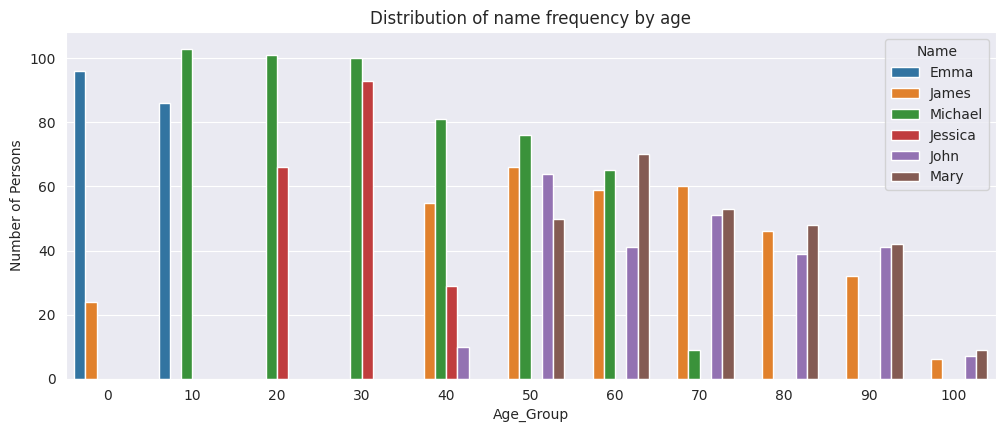

In [110]:
# look at trends in top three names per gender
fig, axis = plt.subplots(figsize=(12, 4.5))
somenames = ["Michael", "James", "Mary", "John", "Jessica", "Emma"]
popular = names[names.Name.isin(somenames)]
sns.countplot(
    x="Age_Group", hue="Name", ax=axis, palette="tab10", data=popular
)
axis.set_title("Distribution of name frequency by age")
axis.set_ylabel("Number of Persons");

This brief investigation shows us that there are substantial differences in the frequencies of names by age (trends) that possibly need to be considered as opposed to using the full population regardless of such trends.

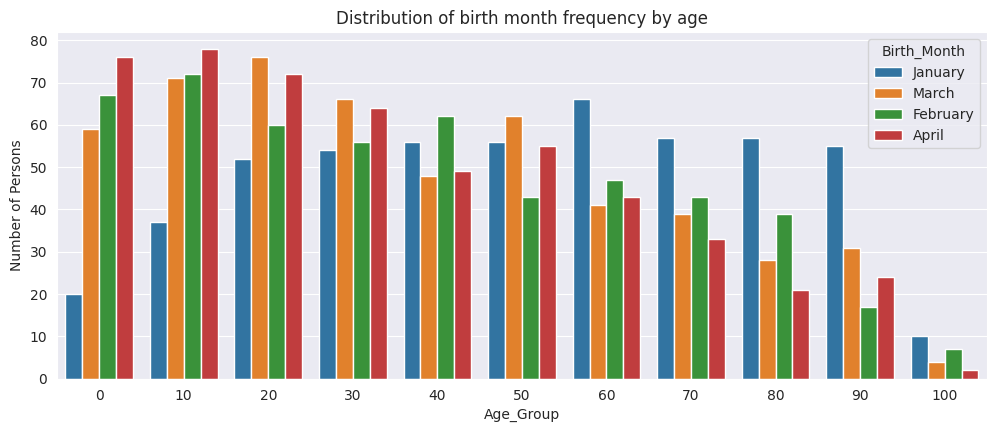

In [111]:
# trends in birth month
fig, axis = plt.subplots(figsize=(12, 4.5))
months = ["January", "February", "March", "April"]
popular = names[names.Birth_Month.isin(months)]
sns.countplot(
    x="Age_Group", hue="Birth_Month", ax=axis, palette="tab10", data=popular
)
axis.set_title("Distribution of birth month frequency by age")
axis.set_ylabel("Number of Persons");

Based on this analysis, there seems to be a trend towards less births in January for younger people. To make sure that this is not based on e.g., the sampling strategy, we further investigate this. I.e., we investigate irregularities in data (e.g., are there any differences in the spread of one variable in relation to the other?) We observe that the number of people per age group gets less with increasing age. We could hence, for instance, count the number of records for each age group and birth month and look into any particularities.

In [112]:
# cross check this fact by age group
month_names = np.array(
    """
    January February March April May
    June July August September October
    November December""".split()
)

# group by age group, count birth months and cross-tabulate
by_month = names.groupby("Age_Group").Birth_Month.value_counts().unstack()

# sort
by_month = by_month[month_names]
by_month

Birth_Month,January,February,March,April,May,June,July,August,September,October,November,December
Age_Group,,,,,,,,,,,,
0,20,67,59,76,66,77,71,65,67,67,56,63
10,37,72,71,78,70,73,82,81,83,79,70,79
20,52,60,76,72,65,65,71,66,68,75,76,71
30,54,56,66,64,73,58,87,82,66,65,57,58
40,56,62,48,49,45,50,58,55,56,66,68,60
50,56,43,62,55,53,43,58,48,53,58,52,46
60,66,47,41,43,54,34,41,51,50,32,52,37
70,57,43,39,33,39,36,45,34,38,30,37,37
80,57,39,28,21,31,37,23,28,27,31,34,37


The larger the size of the age group, the larger the variance and standard deviation of contained values. Hence, we normalize the variance by dividing the raw count within the age group of all months.

In [113]:
by_month.var(axis=1) / by_month.sum(axis=1)

Age_Group
0      0.289808
10     0.172563
20     0.061524
30     0.138908
40     0.077120
50     0.059772
60     0.169321
70     0.104118
80     0.227215
90     0.284632
100    0.079604
dtype: float64

These results show that in the age groups 0 and 80, 90 show a higher normalized variance than the middle aged groups. This can suggest that indeed some bias occurred during the data collection. Whether or not this bias actually matters is dependent on the actual analysis to be performed.

### Compare distributions to baselines

In the following example, we will look at the distribution of home location in the names dataset and compare them to US population data. The US population data was taken from CleanData (https://github.com/PacktPublishing/Cleaning-Data-for-Effective-Data-Science/blob/main/data/state-population.csv).

In [114]:
# read in baseline: state population statistics
states = pd.read_csv(
    os.path.join(data_dir, "state-population.csv"), delimiter="|"
)
states

,State,Population_2019,Population_2010,House_Seats
0,California,39512223,37254523,53.0
1,Texas,28995881,25145561,36.0
2,Florida,21477737,18801310,27.0
3,New_York,19453561,75459,NaN
4,Pennsylvania,12801989,12702379,18.0
5,Illinois,12671821,12830632,18.0
6,Ohio,11689100,11536504,16.0
7,Georgia,10617423,9687653,14.0
8,North_Carolina,10488084,9535483,13.0
9,Michigan,9986857,9883640,14.0


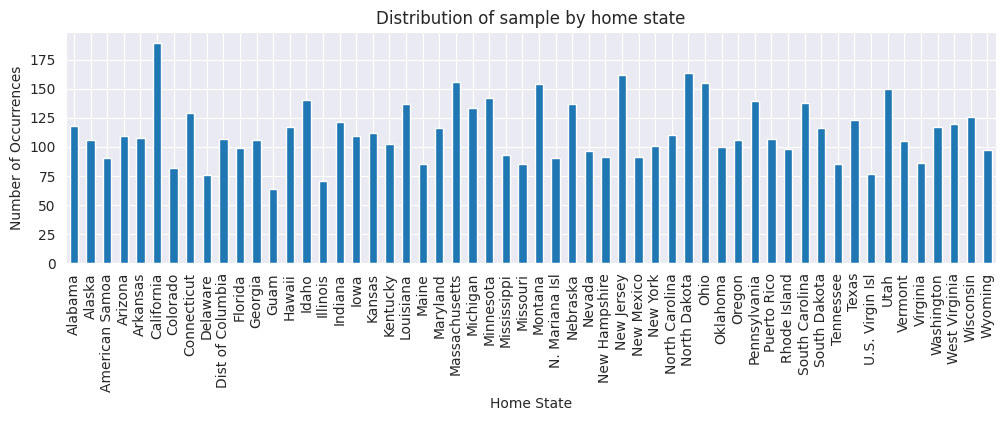

In [115]:
# look at distribution of home location in dataset
(
    names.Home.value_counts()
    .sort_index()
    .plot(
        kind="bar",
        figsize=(12, 3),
        title="Distribution of sample by home state",
        xlabel="Home State",
        ylabel="Number of Occurrences",
    )
);

To be able to contextualize this distribution, we compare it to a dataset of US population per state.

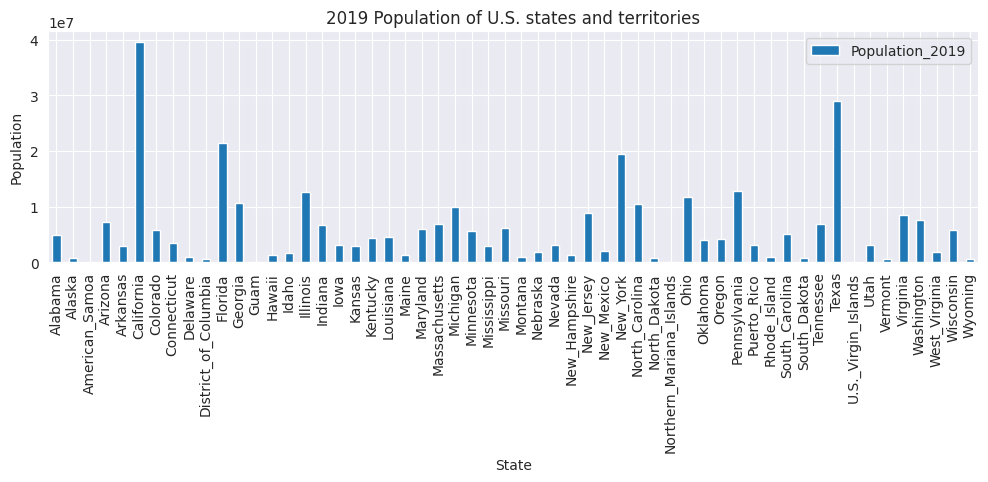

In [116]:
# compare to dataset of population per state
(
    states.sort_values("State")[["State", "Population_2019"]]
    .set_index("State")
    .plot(
        kind="bar",
        figsize=(12, 3),
        title="2019 Population of U.S. states and territories",
        xlabel="State",
        ylabel="Population",
    )
);

This comparison shows us that smaller states are overrepresented in the dataset (selection bias based on size of each state). Without any informatio about how this data was collected, we do not know about the causes of this imbalance (e.g., sampling could be based on some feature not present in this dataset). 

### Class Imbalance

The following example is based on Apache server logs (adapted from CleanData) and shows an analysis of server http responses. The data was collected by the author of CleanData (basically, the Apache logs of his server over a period of two weeks (gnosis.cx)): https://github.com/PacktPublishing/Cleaning-Data-for-Effective-Data-Science/tree/main/data/gnosis.

Firstly, inspect file contents (zcat = cat for compressed files).

In [117]:
%%bash
zcat ../data/gnosis/20200330.log.gz | head -5

162.158.238.207 - - [30/Mar/2020:00:00:00 -0400] "GET /TPiP/024.code HTTP/1.1" 200 75
173.245.54.204 - - [30/Mar/2020:00:01:46 -0400] "GET /download/gnosis/xml/pickle/test/test_rawp_sre.py HTTP/1.1" 200 2080
162.158.167.141 - - [30/Mar/2020:00:03:02 -0400] "GET /TPiP/154.code HTTP/1.1" 200 67
162.158.166.86 - - [30/Mar/2020:00:10:25 -0400] "GET /TPiP/103.code HTTP/1.1" 200 510
162.158.34.7 - - [30/Mar/2020:00:12:21 -0400] "GET /publish/rss.xml HTTP/1.1" 403 199


In [118]:
def apache_log_to_df(fname):
    # Read one log file.  Treat is as a space separated file
    # There is no explicit header, so we assign columns
    columns = [
        "ip_address",
        "ident",
        "userid",
        "timestamp",
        "tz",
        "request",
        "status",
        "size",
    ]
    logs = pd.read_csv(fname, sep=" ", header=None, names=columns)

    # The first pass gets something workable, but refine it
    # Datetime has superfluous '[', but fmt matches that
    date_format = "[%d/%b/%Y:%H:%M:%S"
    logs["timestamp"] = pd.to_datetime(logs.timestamp, format=date_format)

    # Convert timezone to an integer
    logs["tz"] = logs.tz.str[:3].astype(int)

    # Break up the quoted request into sub-components
    logs[["method", "resource", "protocol"]] = logs.request.str.split(
        " ", expand=True
    )

    # Break the IP address into each quadrant
    logs[
        ["quadrant1", "quadrant2", "quadrant3", "quadrant4"]
    ] = logs.ip_address.str.split(".", expand=True)

    # Pandas lets us pull components from datetime
    logs["hour"] = logs.timestamp.dt.hour
    logs["minute"] = logs.timestamp.dt.minute

    # Split resource into the path/directory vs. actual page
    logs[["path", "page"]] = logs.resource.str.rsplit("/", n=1, expand=True)
    # Only care about some fields for current purposes
    cols = [
        "hour",
        "minute",
        "quadrant1",
        "quadrant2",
        "quadrant3",
        "quadrant4",
        "method",
        "path",
        "page",
        "status",
    ]
    return logs[cols]

In [119]:
# read in individual log files, concat to single df
requests = pd.concat(
    map(apache_log_to_df, glob.glob("../data/gnosis/*.log.gz"))
)
# Each file has index from 0, so dups occur in raw version
requests = requests.reset_index().drop("index", axis=1)
# The /16 subnetwork is too random for this purpose
requests.drop(["quadrant3", "quadrant4"], axis=1, inplace=True)
requests

,hour,minute,quadrant1,quadrant2,method,path,page,status
0,0,1,108,162,GET,/download/gnosis/xml/pickle/ext,,200
1,0,4,162,158,GET,/download/relax,rnc2rng,200
2,0,10,162,158,GET,/publish,rss.xml,403
3,0,10,162,158,GET,/publish/programming,charming_python_6.html,200
4,0,12,172,69,GET,/download/gnosis/xml/pickle/doc,THANKS_TO,200
...,...,...,...,...,...,...,...,...
13446,23,56,162,158,GET,/publish/images,gopher.gif,304
13447,23,56,162,158,GET,/publish,eye.ico,304
13448,23,56,108,162,GET,/publish/images,subtlestripe.gif,304
13449,23,56,162,158,GET,/publish/images,note.gif,304


In a next step, we look at different distributions of log data (per hour, minute, but also per method, status or IP-quadrant 1 and 2).

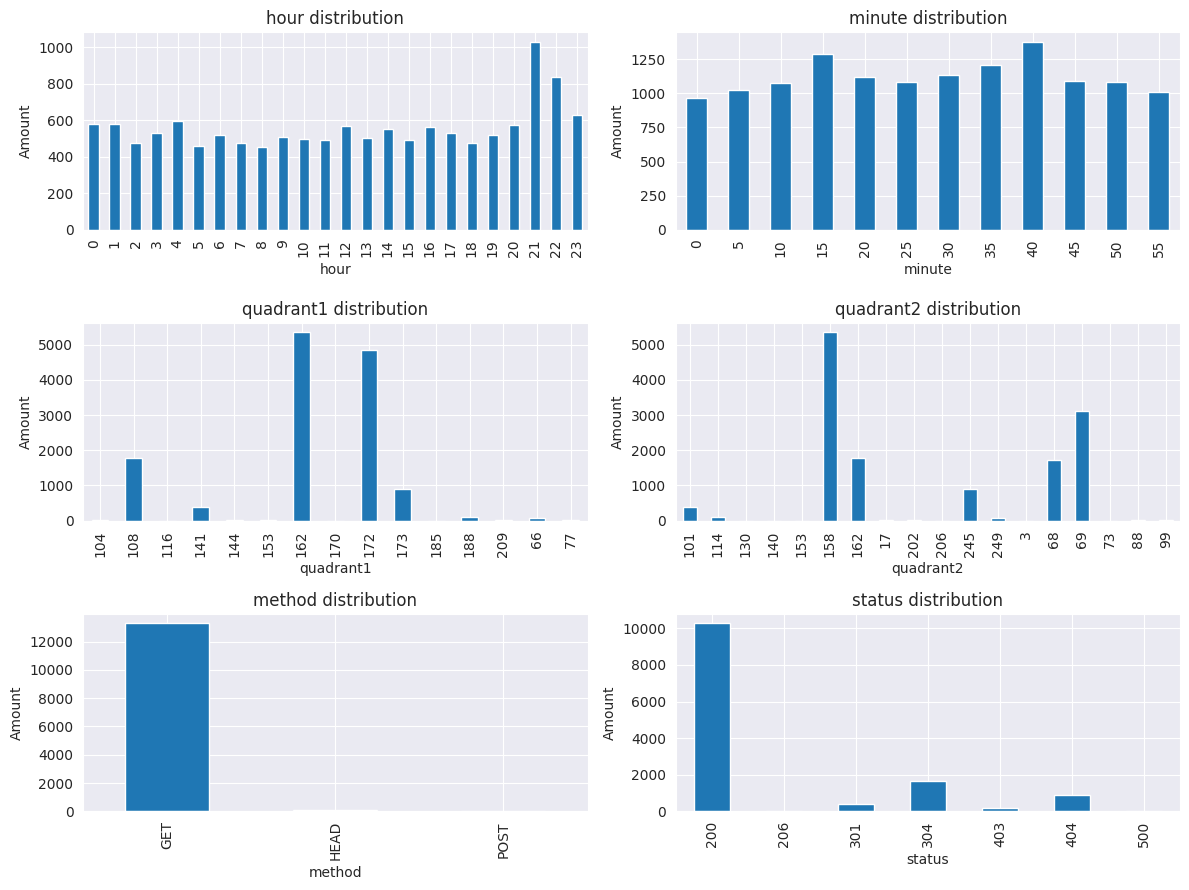

In [120]:
# plot different distributions as bar charts
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

# Which factors should we analyze for class balance?
factors = ["hour", "minute", "quadrant1", "quadrant2", "method", "status"]

# Loop through the axis subplots and the factors
for col, ax in zip(factors, axes.flatten()):
    # Minute is categorical but too many so quantize
    if col == "minute":
        data = (requests[col] // 5 * 5).value_counts()
    else:
        data = requests[col].value_counts()

    # sort x-axis
    data = data.sort_index()
    data.plot(kind="bar", ax=ax)
    ax.set_title(f"{col} distribution")
    ax.set_xlabel(col)
    ax.set_ylabel("Amount")

# Matplotlib trick to improve spacing of subplots
fig.tight_layout();

This example shows that there multiple imbalanced classes, but also some rather balanced samples. For instance, 162 and 172 (quadrant1) are of the content delivery network the server uses.

### Normalization and Scaling

Example based on synthetic data, aims to show the impact of normalization and scaling of properties.

In a first step, we create synthetic data by creating a target value between 10 and 20 and two features: one feature contains small values, with smaller standard deviation; the second feature is larger and features higher standard deviation. 

In [121]:
# Synthetic data to illustrate scaling
def make_unscaled_features(N=200, j1=1 / 50, j2=1 / 10):
    """Create DataFrame of synthetic data

    Feature_1 will be:
      * positively correlated with Target
      * numerically small values
    Feature_2 will be:
      * negatively correlatged with Target
      * numerically large values

    N  - number of rows to geneate
    j1 - the relative scale of random jitter for F1
    j2 - the relative scale of random jitter for F2
    """
    assert j2 > j1
    # Repeatable randomness
    np.random.seed(1)

    # Target points range from 10 to 20, evenly spaced.
    target = np.linspace(10, 20, N)

    # Feature_1 is roughly 1/100th size of Target
    # draw random sample from normally distributed population
    # with given spread/scale/standard deviation
    feat1 = target / 100
    feat1 += np.random.normal(loc=0, scale=np.max(feat1) * j1, size=N)

    # Feature_2 is around 20,000
    feat2 = np.linspace(21_000, 19_000, N)
    feat2 += np.random.normal(loc=0, scale=np.max(feat2) * j2, size=N)

    df = pd.DataFrame(
        {"Feature_1": feat1, "Feature_2": feat2, "Target": target}
    )
    sample = df.sample(frac=1)
    # reset index of samples
    return sample.reset_index().drop("index", axis=1)

In [122]:
unscaled = make_unscaled_features()
unscaled

,Feature_1,Feature_2,Target
0,0.112999,19247.756104,11.407035
1,0.204178,23432.270613,20.000000
2,0.173678,19179.445753,17.336683
3,0.161411,17579.625264,16.633166
4,0.192209,19255.160726,19.095477
...,...,...,...
195,0.110874,20213.848541,10.502513
196,0.137692,20934.654450,13.316583
197,0.184393,18855.241195,18.241206
198,0.177846,19760.314890,17.839196


In [123]:
# is there a univariate correlation with target?
unscaled.corr()

,Feature_1,Feature_2,Target
Feature_1,1.000000,-0.272963,0.992514
Feature_2,-0.272963,1.000000,-0.269406
Target,0.992514,-0.269406,1.000000


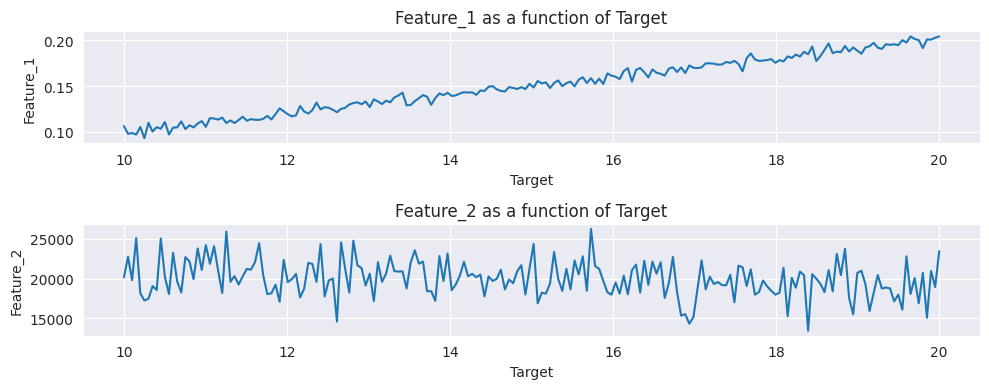

In [124]:
def plot_univariate_trends(df, Target="Target"):
    df = df.sort_values(Target)
    target = df[Target]
    X = df.drop(Target, axis=1)
    n_feat = len(X.columns)
    fig, axes = plt.subplots(n_feat, 1, figsize=(10, n_feat * 2))
    for ax, col in zip(axes, X.columns):
        ax.plot(target, X[col])
        ax.set_title(f"{col} as a function of {Target}")
        ax.set_xlabel(f"{Target}")
        ax.set_ylabel(f"{col}")

    fig.tight_layout()


plot_univariate_trends(unscaled)

From visual inspection, we can see that feature 1 clearly has a positive correlation with the target, whereas feature 2 does not. Next we apply a simple regression model on the unscaled data.

In [125]:
X = unscaled.drop("Target", axis=1)
y = unscaled["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# The target is predicted by local interpolation of the targets associated
# of the nearest neighbors in the training set.
knn = KNeighborsRegressor()
knn.fit(X_train, y_train).score(X_test, y_test)

0.027756186064182953

In a first step, we use the MinMax scaler, leading to features that are all within [0,1].

In [126]:
# use MinMaxScaler -> all X features now scaled between 0 and 1
X_scaled = MinMaxScaler().fit_transform(X)

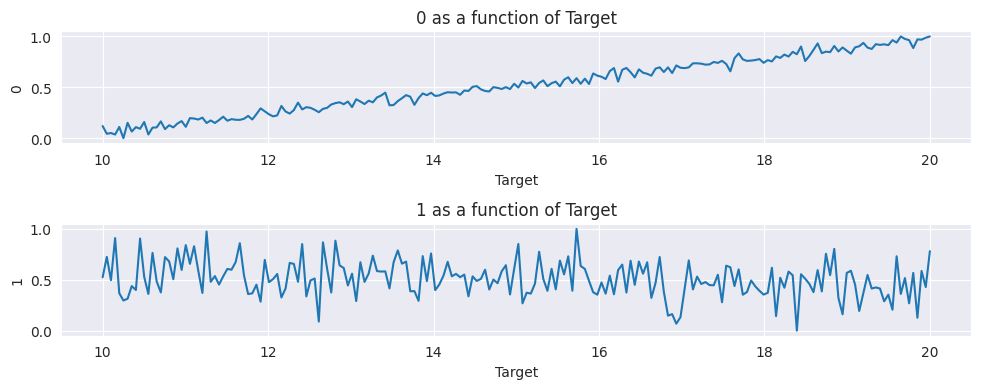

In [127]:
plot_univariate_trends(
    pd.concat([pd.DataFrame(X_scaled), unscaled["Target"]], axis=1)
)

In [128]:
# apply the regression model again on scaled data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, random_state=1
)

knn_scaled = KNeighborsRegressor()
knn_scaled.fit(X_train, y_train).score(X_test, y_test)

0.9743878175626131

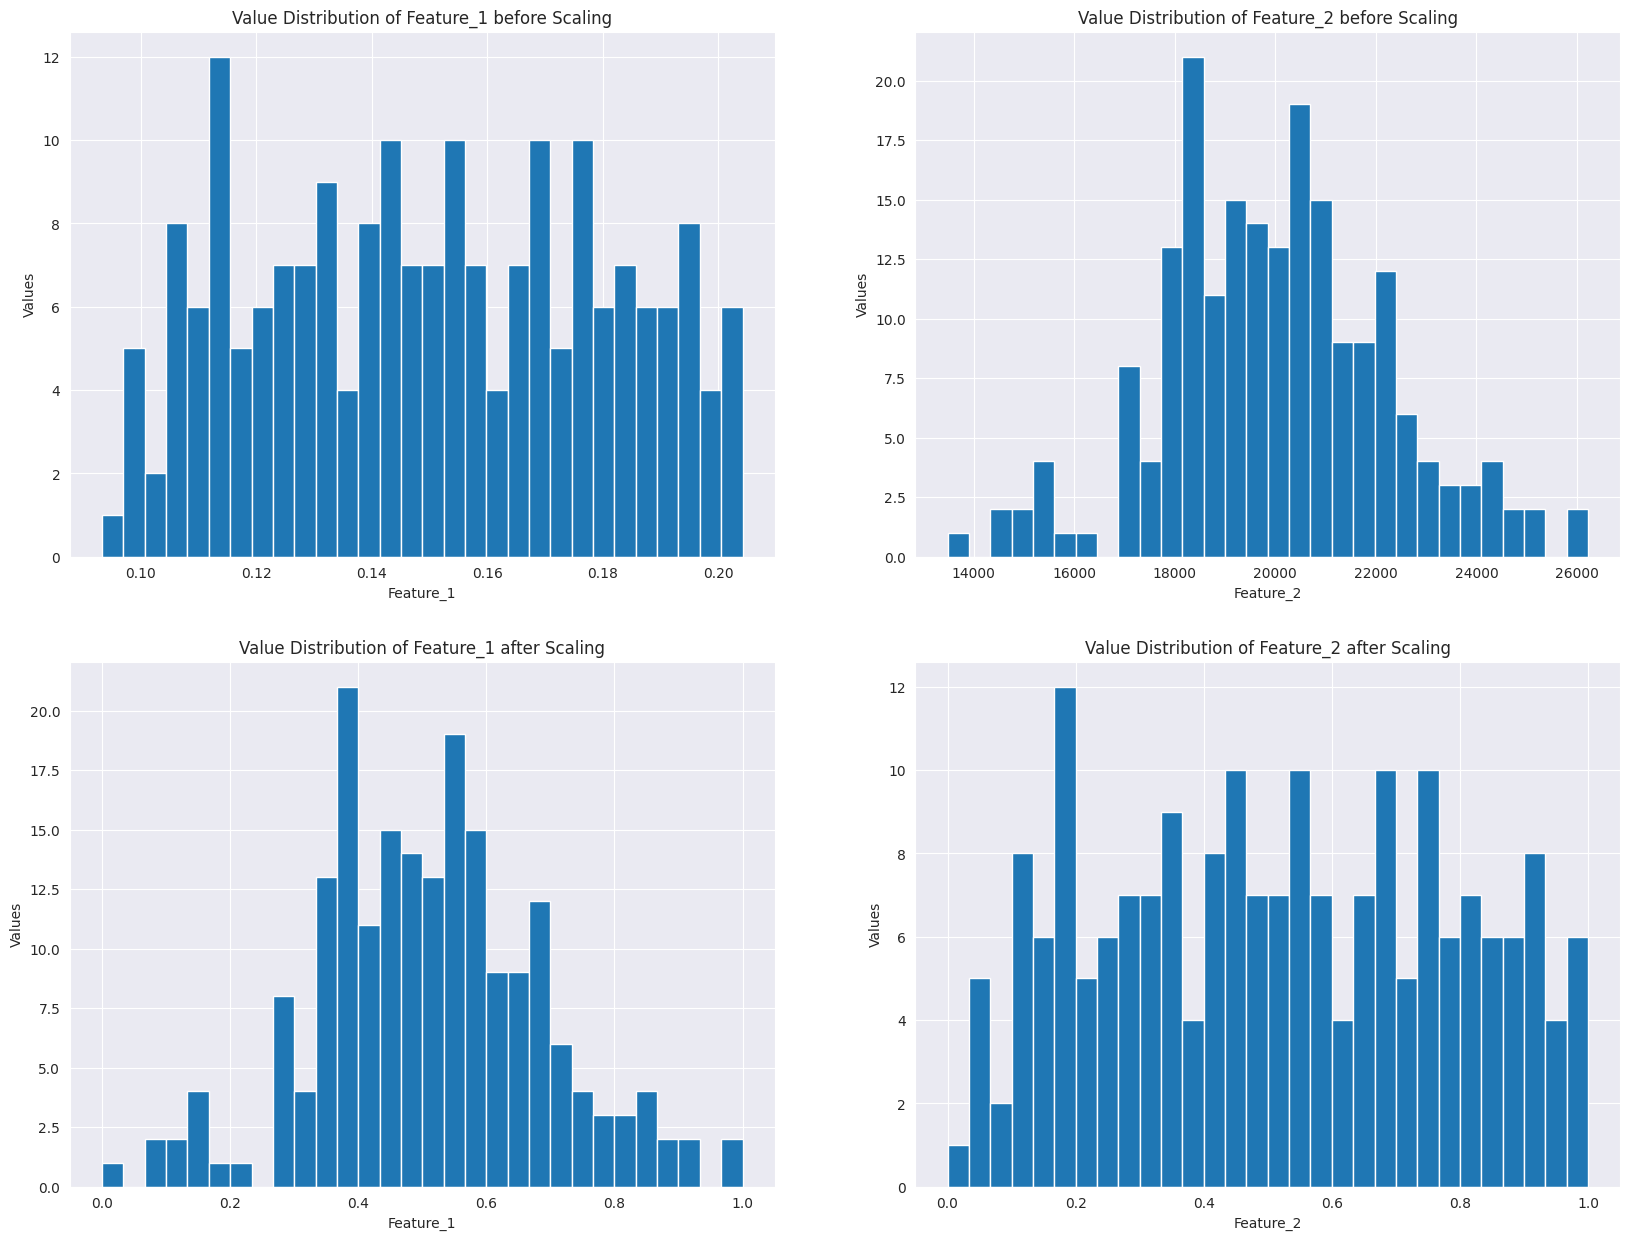

In [129]:
# inspect changes in distribution before and after scaling
# we are inspecting a histogram here - scaling on the x-axis!
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = {"Feature_1", "Feature_2"}

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes[0, 0].hist(X["Feature_1"], bins=30)
axes[0, 0].set_title("Value Distribution of Feature_1 before Scaling")
axes[0, 0].set_xlabel("Feature_1")
axes[0, 0].set_ylabel("Values")

axes[0, 1].hist(X["Feature_2"], bins=30)
axes[0, 1].set_title("Value Distribution of Feature_2 before Scaling")
axes[0, 1].set_xlabel("Feature_2")
axes[0, 1].set_ylabel("Values")

axes[1, 0].hist(X_scaled["Feature_1"], bins=30)
axes[1, 0].set_title("Value Distribution of Feature_1 after Scaling")
axes[1, 0].set_xlabel("Feature_1")
axes[1, 0].set_ylabel("Values")

axes[1, 1].hist(X_scaled["Feature_2"], bins=30)
axes[1, 1].set_title("Value Distribution of Feature_2 after Scaling")
axes[1, 1].set_xlabel("Feature_2")
axes[1, 1].set_ylabel("Values");

StandardScaler sets the mean of a given feature to 0 and the standard deviation to 1. This is particularly done when the variable is normally distributed.

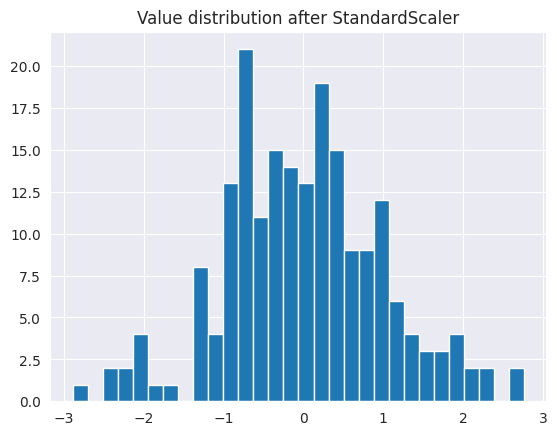

In [130]:
X_standardscaled = StandardScaler().fit_transform(X)

# Second column for example (both were scaled)
plt.hist(X_standardscaled[:, 1], bins=30)
plt.title("Value distribution after StandardScaler");

In [131]:
X_standardscaled.mean()
X_standardscaled.std()

np.float64(3.0531133177191805e-16)

np.float64(0.9999999999999999)